In [56]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import Optimizer
from IPython.display import clear_output
from tqdm import tqdm

In [57]:
df = pd.read_csv('../data/processed_data.csv')
features = list(df.columns)[:-2]
labels = list(df.columns)[-2:]

X = df[features].to_numpy()
# Note that we have 2 labels
Y = df[labels].to_numpy()

In [58]:
def normalize(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    return (X - means) / stds

In [59]:
X_norm = normalize(X)

In [60]:
# The commonly used split of 75% for training, 10% for validation, and 15%
# for the test sets has been followed when splitting the dataset.

X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.25, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.6, random_state=42)

# y1: WaveHeight
y1_train = Y_train[:,0]
y1_val = Y_val[:,0]
y1_test = Y_test[:,0]

# y2: WavePeriod
y2_train = Y_train[:,1]
y2_val = Y_val[:,1]
y2_test = Y_test[:,1]

In [61]:
def finding_polynomial(X_train, X_val, y_train, y_val, highest_degree):
    # define a list of values for polynomial degrees
    degrees = [i for i in range(1, highest_degree + 1)]
    # declare a variable to store the resulting validation errors for each polynomial degree
    train_errors = []
    val_errors = []
    r2_vals = []
    for i in range(len(degrees)):    # use for-loop to fit polynomial regression models with different degrees

        poly = PolynomialFeatures(degree=degrees[i])
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)

        regression = LinearRegression()
        regression.fit(X_train_poly, y_train)

        y_train_pred = regression.predict(X_train_poly)
        y_pred = regression.predict(X_val_poly)

        train_error = mean_squared_error(y_train, y_train_pred)
        val_error = mean_squared_error(y_val, y_pred)
        r2_val = r2_score(y_val, y_pred)

        train_errors.append(train_error)
        val_errors.append(val_error)
        r2_vals.append(r2_val)

    return train_errors, val_errors, r2_vals

In [62]:
def plotting_errors(train_errors: list[float], val_errors: list[float], highest_degree: int, title: str):
    degrees = [i for i in range(1, highest_degree + 1)]

    plt.figure(figsize=(16, 8))
    plt.title(title)

    plt.plot(degrees, train_errors, label='Training Error', color='blue')
    plt.plot(degrees, val_errors, label='Validation Error', color='red')

    plt.xlabel('Polynomial Degree')
    plt.ylabel('Mean Squared Error')
    plt.legend()

    plt.show()

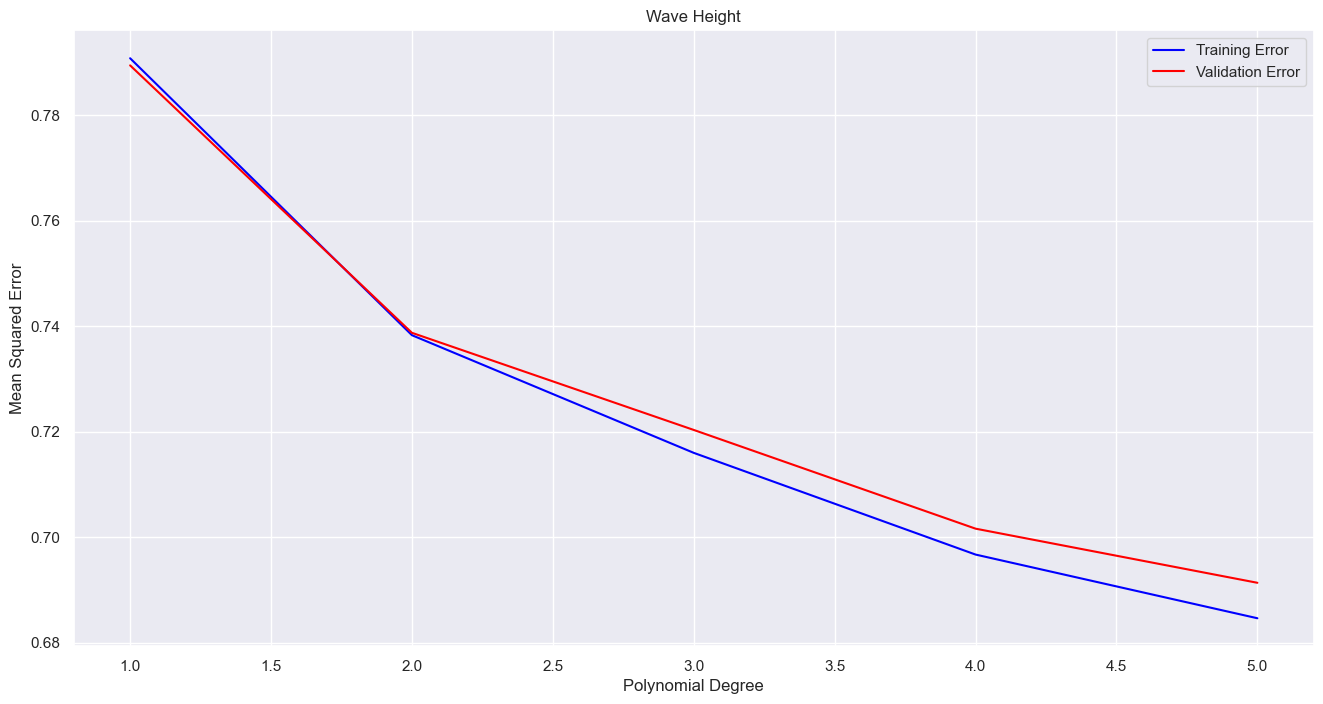

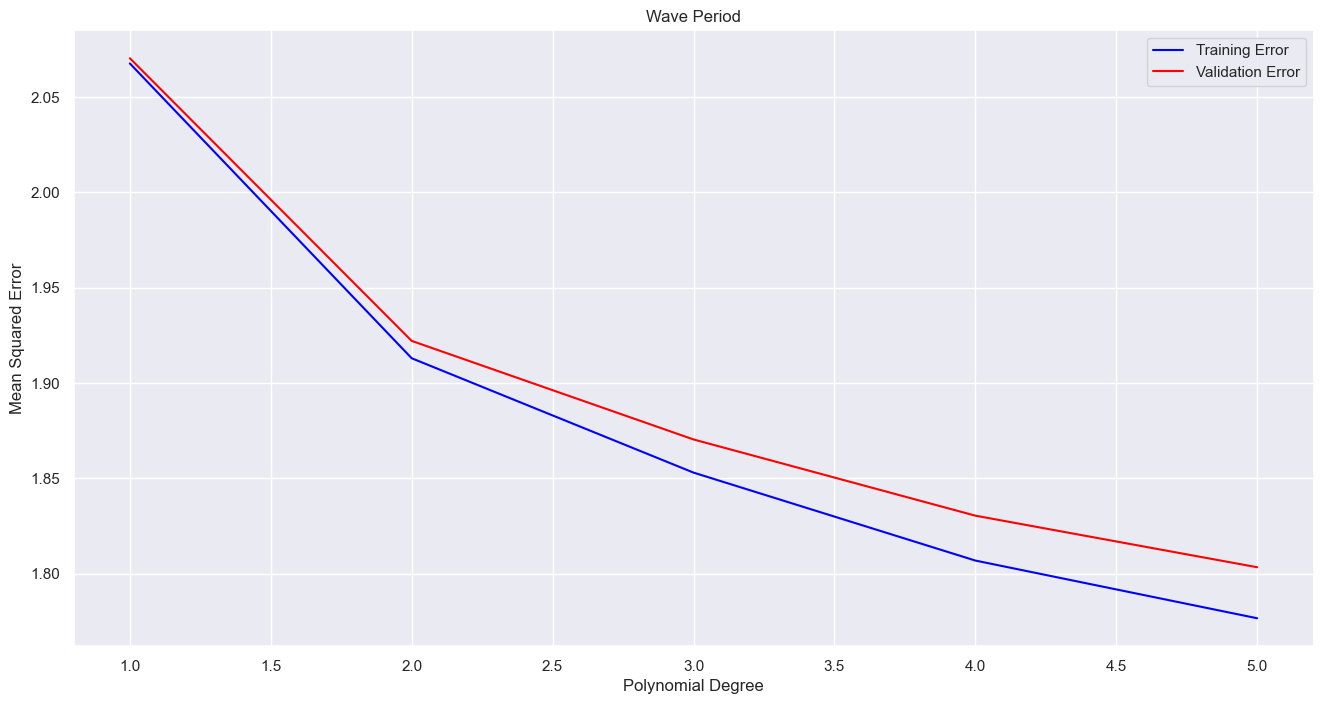

Degree 1: R^2 Wave Height 0.431; R^2 Wave Period 0.136.
Degree 2: R^2 Wave Height 0.468; R^2 Wave Period 0.198.
Degree 3: R^2 Wave Height 0.481; R^2 Wave Period 0.219.
Degree 4: R^2 Wave Height 0.495; R^2 Wave Period 0.236.
Degree 5: R^2 Wave Height 0.502; R^2 Wave Period 0.247.


In [63]:
highest_degree = 5

(train_errors_1, val_errors_1, r2_scores_1) = finding_polynomial(X_train, X_val, y1_train, y1_val, highest_degree)
(train_errors_2, val_errors_2, r2_scores_2) = finding_polynomial(X_train, X_val, y2_train, y2_val, highest_degree)

plotting_errors(train_errors_1, val_errors_1, highest_degree, "Wave Height")
plotting_errors(train_errors_2, val_errors_2, highest_degree, "Wave Period")

for deg, (r2_score_1, r2_score_2) in enumerate(zip(r2_scores_1, r2_scores_2)):
    print(f"Degree {deg+1}: R^2 Wave Height {r2_score_1:.3f}; R^2 Wave Period {r2_score_2:.3f}.")

In [53]:
def testing_polynomial(X_train, X_test, y_train, y_test, degree_of_choice=4):
    poly = PolynomialFeatures(degree=degree_of_choice)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)

    regression = LinearRegression()
    regression.fit(X_train_poly, y_train)

    y_pred = regression.predict(X_test_poly)

    ms_error = mean_squared_error(y_test, y_pred)
    r2_val = r2_score(y_test, y_pred)
    return ms_error, r2_val

In [54]:
ms_error_1, r2_val_1 = testing_polynomial(np.vstack((X_train, X_val)), X_test, np.hstack((y1_train, y1_val)), y1_test)

ms_error_2, r2_val_2 = testing_polynomial(np.vstack((X_train, X_val)), X_test, np.hstack((y2_train, y2_val)), y2_test)

print(f"Mean Squared Error for Wave Height: {ms_error_1:.3f}.")
print(f"R^2 for Wave Height: {r2_val_1:.3f}.")
print(f"Mean Squared Error for Wave Period: {ms_error_2:.3f}.")
print(f"R^2 for Wave Period: {r2_val_2:.3f}.")

Mean Squared Error for Wave Height: 0.705.
R^2 for Wave Height: 0.501.
Mean Squared Error for Wave Period: 1.821.
R^2 for Wave Period: 0.238.


In [13]:
class Network1(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(7, 64)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(64, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.2)

        self.linear3 = nn.Linear(128, 64)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)

        self.linear4 = nn.Linear(64, 2)

        self.activation = nn.ReLU()

    def forward(self, x):
        output = self.linear1(x)
        output = self.batch_norm1(output)
        output = self.activation(output)
        output = self.dropout1(output)

        output = self.linear2(output)
        output = self.batch_norm2(output)
        output = self.activation(output)
        output = self.dropout2(output)

        output = self.linear3(output)
        output = self.batch_norm3(output)
        output = self.activation(output)
        output = self.dropout3(output)

        output = self.linear4(output)

        return output

In [14]:
sns.set_theme(style='darkgrid')

def plot_stats(train_loss: list[float], valid_loss: list[float], title: str):

    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Validation loss')

    plt.legend()

    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.show()

In [15]:
def train(model: nn.Module, data_loader: DataLoader, opt: Optimizer, loss_fn):

    model.train()

    total_loss = 0

    for i, (x, y) in enumerate(tqdm(data_loader)):
        opt.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        total_loss += loss.item()
        opt.step()

    return total_loss / len(data_loader)

In [16]:
@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn):

    model.eval()

    total_loss = 0

    for i, (x, y) in enumerate(tqdm(data_loader)):
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [17]:
def fit(model, train_loader, valid_loader, opt, loss_fn, num_epochs, title):

    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, opt, loss_fn)
        valid_loss = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output()

        plot_stats(train_loss_history, valid_loss_history, title)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
device

device(type='cpu')

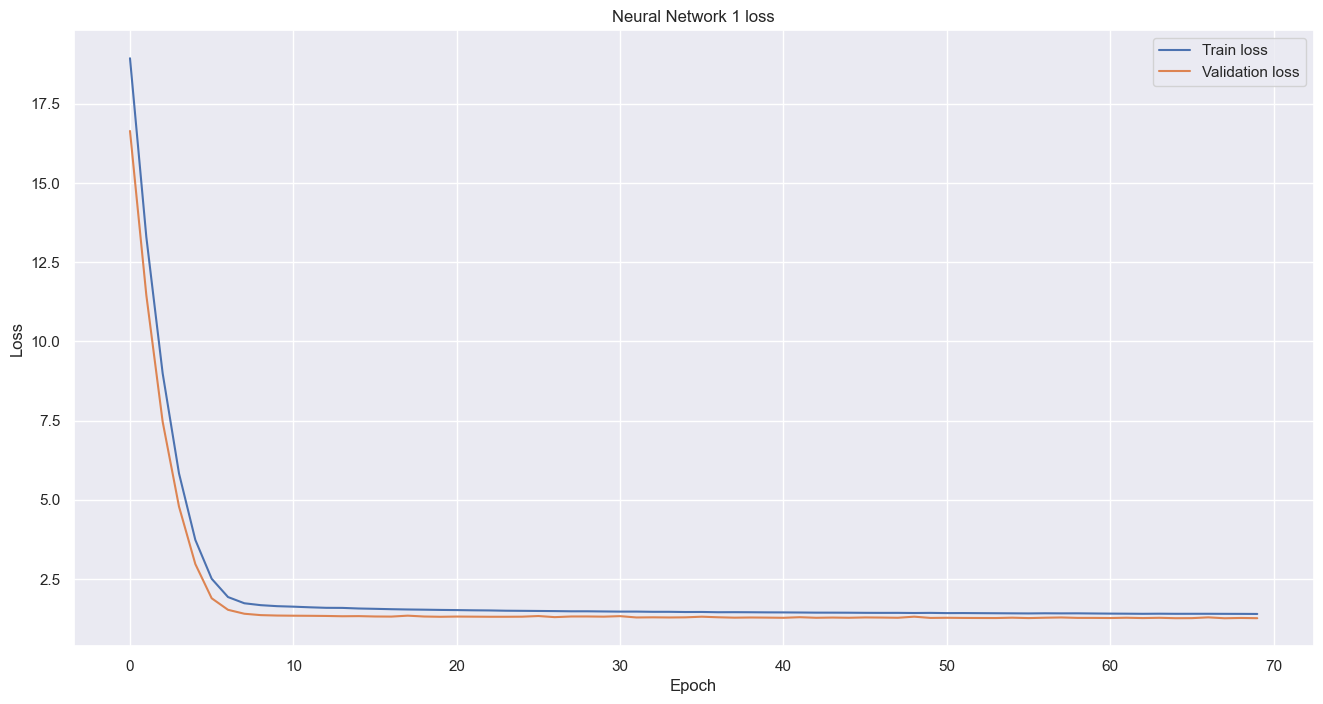

In [20]:
dataset = TensorDataset(
    torch.from_numpy(X).float().to(device),
    torch.from_numpy(Y).float().to(device)
)

train_dataset, valid_dataset = random_split(
    dataset,
    (int(len(dataset) * 0.8), len(dataset) -  int(len(dataset) * 0.8)),
    generator=torch.Generator()
)

net = Network1().to(device)

optimizer = optim.Adam(net.parameters(), lr=5e-5)
loss_function = nn.MSELoss()
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False)
fit(net, train_loader, valid_loader, optimizer, loss_function, 70, 'Neural Network 1')